# Importing packages and load CNN

In [1]:
# Load the extension
%load_ext autoreload
# Autoreload all modules
%autoreload 2

In [26]:
from funcs import *

# Telling the notebook to make plots inline.
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

## Start camera and DAC

In [4]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
print("Using Camera ", camera.GetDeviceInfo().GetModelName())
camera.Open()

# Sanity checks
print('Camera Auto Gain is :', camera.GainAuto())
if camera.GainAuto() == 'Off':
    print('Safe to go ahead with the code..')
else:
    print('***Warning: Camera Auto Gain is ON!***\nTurn it off using Pylon software.')
camera.ExposureTimeAbs = Exposure

# Start DAC
start_channel = 1
bus = busworks.BusWorks_DAC()
bus.start()
print("DAC on IP: ", bus.address)

Using Camera  acA720-290gm
Camera Auto Gain is : Off
Safe to go ahead with the code..
DAC on IP:  192.168.1.231


## Initial State

Initial condition: 26.724365234375


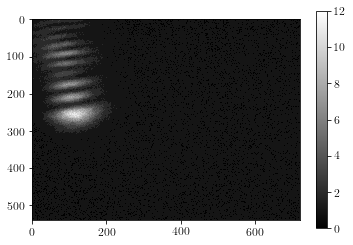

In [27]:
Img_initial = Capture_image(1000, camera)
print('Initial condition: {}'.format(Img_initial.sum()/n_pixl**2))
plt.imshow(Img_initial[::-1], cmap=cm.binary_r)
plt.colorbar()

In [28]:
# Initial condition of beam
current_beam_status = np.zeros(num_params)

## Alignment loop



Range: 3.5 x waist


 Gen: 0 Range: 2.4260069510430124 x waist
Time: 13.443644762039185, Fittest Parent: [-4.32364019e-04  1.27814145e-03 -2.09335315e-05 -7.84235561e-04
 -1.01757624e-07], Fitness: 32.1019287109375


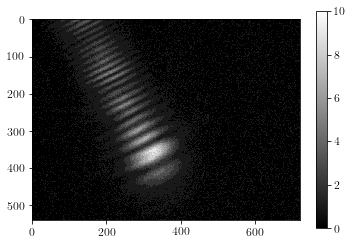



 Gen: 1 Range: 1.6815742075740037 x waist
Time: 27.117692470550537, Fittest Parent: [-2.93764597e-04 -1.05451710e-03 -2.61182942e-03 -1.03685859e-03
 -7.91123389e-07], Fitness: 27.3424072265625


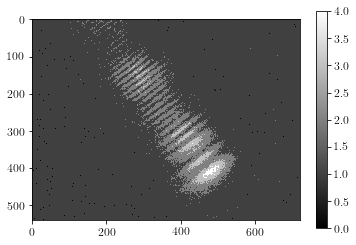



 Gen: 2 Range: 1.1655744903626222 x waist
Time: 40.79229402542114, Fittest Parent: [-2.07491050e-04 -8.11582356e-04 -7.66637987e-04 -4.45162793e-03
  2.89805531e-07], Fitness: 29.194580078125


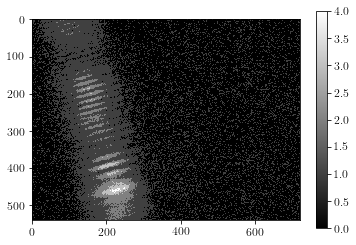



 Gen: 3 Range: 0.8079119473080394 x waist
Time: 54.47438144683838, Fittest Parent: [ 2.30001823e-03  3.49232223e-04  1.01112497e-03  1.23582538e-03
 -2.63100530e-07], Fitness: 28.5888671875


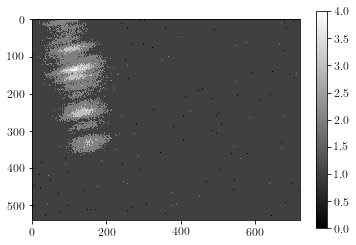



 Gen: 4 Range: 0.5599999999999998 x waist
Time: 68.14988708496094, Fittest Parent: [ 4.66122760e-05 -9.78581420e-05 -1.39989846e-03  9.20197790e-04
 -1.42258837e-08], Fitness: 38.97613525390625


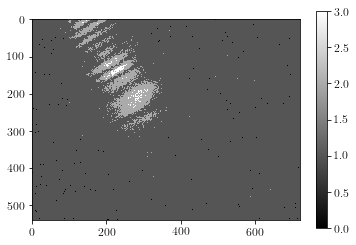



 Gen: 5 Range: 0.3881611121668818 x waist
Time: 81.81756854057312, Fittest Parent: [ 2.34324334e-03 -1.04883220e-03 -1.46541168e-03 -2.46275485e-03
  4.31167982e-07], Fitness: 31.5975341796875


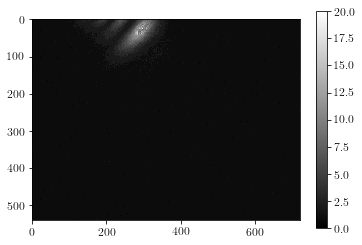



 Gen: 6 Range: 0.2690518732118405 x waist
Time: 95.53514838218689, Fittest Parent: [-1.84016239e-03  8.22148642e-04 -3.79952614e-04 -1.06937949e-05
  2.72540595e-08], Fitness: 38.33782958984375


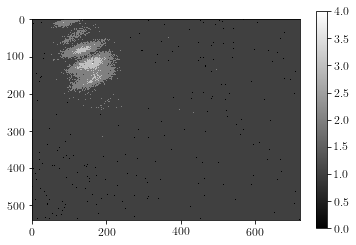



 Gen: 7 Range: 0.1864919184580195 x waist
Time: 109.22346639633179, Fittest Parent: [-1.68951529e-03 -7.63779332e-05 -1.51536572e-03 -1.11797473e-03
 -3.66201907e-07], Fitness: 35.66033935546875


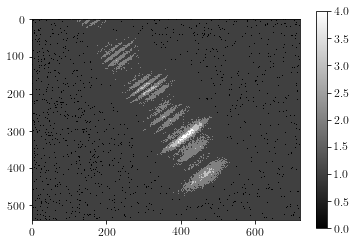



 Gen: 8 Range: 0.12926591156928627 x waist
Time: 122.91441798210144, Fittest Parent: [ 9.69239682e-05  1.86394710e-05  3.17393697e-05 -2.98960463e-04
  3.61178113e-07], Fitness: 35.1158447265625


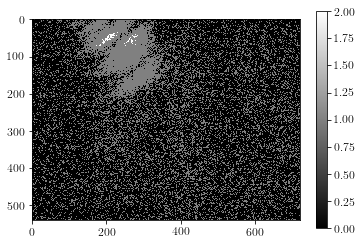



 Gen: 9 Range: 0.08959999999999994 x waist
Time: 136.6136829853058, Fittest Parent: [-1.79826484e-03  1.59862949e-04  1.73464825e-04 -3.81840531e-05
 -4.11096190e-07], Fitness: 34.91265869140625


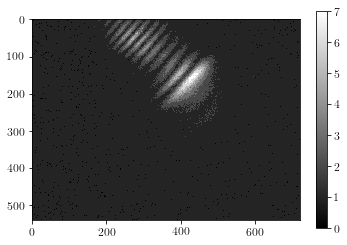



 Gen: 10 Range: 0.06210577794670107 x waist
Time: 150.2985942363739, Fittest Parent: [-6.33374892e-05  1.31029084e-04  1.02588179e-04  1.58706377e-05
 -3.19046935e-08], Fitness: 37.4837646484375


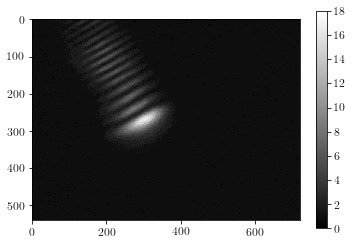



 Gen: 11 Range: 0.04304829971389446 x waist
Time: 164.13907194137573, Fittest Parent: [ 4.19976615e-05  9.71804023e-06  4.21527624e-05  6.71005451e-04
 -3.87562079e-08], Fitness: 44.449951171875


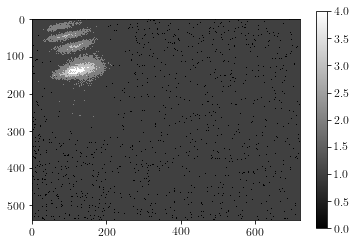



 Gen: 12 Range: 0.029838706953283108 x waist
Time: 177.82721185684204, Fittest Parent: [-1.72029165e-03 -6.10642855e-06  6.14576575e-05  5.98381003e-04
  3.25363214e-09], Fitness: 48.42596435546875


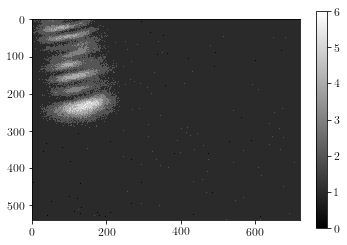



 Gen: 13 Range: 0.020682545851085796 x waist
Time: 191.51238822937012, Fittest Parent: [-2.74121955e-06 -1.85610596e-05 -6.59205943e-05  2.04795054e-05
 -3.07903540e-07], Fitness: 32.86285400390625


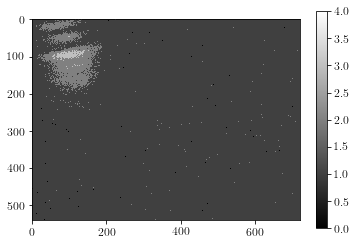



 Gen: 14 Range: 0.014335999999999986 x waist
Time: 205.20342111587524, Fittest Parent: [-7.23932636e-06 -1.18413130e-05  9.18626583e-05 -3.98419670e-05
  2.55633806e-09], Fitness: 34.04833984375


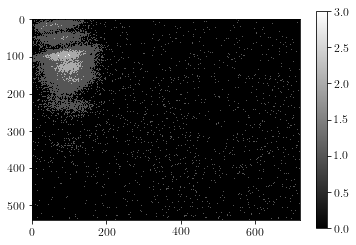



 Gen: 15 Range: 0.009936924471472168 x waist
Time: 218.88778924942017, Fittest Parent: [ 1.40482645e-05 -1.11794261e-05  1.16637632e-04 -3.29705552e-05
  1.90935757e-09], Fitness: 30.890625


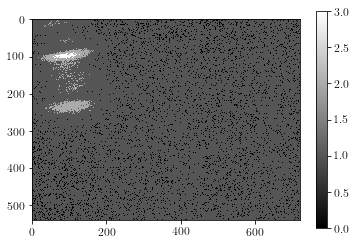

In [29]:
# Creating the initial population of deltas
new_pop_deltas = sample_d(Range, shape=pop_size)
print("\n\nRange:", Range, "x waist")
sess = tf.Session()

gen = 0
dont_alter_z_cm = False
t0 = time.time()

# GA loop
for gen in range(16):
    # Shrink range
    Range *= shrink_factor
    print("\n\n Gen: {} Range: {} x waist".format(gen, Range))
    if dont_alter_z_cm:
        new_pop_deltas[:,-1] = 0.
    if gen == 0:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, camera, bus, only_offsprings=False)
    else:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, camera, bus, only_offsprings=True)
    # Selecting the best parents in the population for mating.
    current_beam_status, parents, parents_fitness, Img_is_saturated, image = select_mating_pool(current_beam_status, new_pop_deltas, fitness, num_parents_mating, t0, gen, camera, bus, \
                           show_the_best=True, save_best=False)
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, (pop_per_gen - num_parents_mating, num_params))
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, Range)
    # Creating the new population based on the parents and offspring.
    new_pop_deltas[:num_parents_mating, :] = parents
    new_pop_deltas[num_parents_mating:, :] = offspring_mutation
    fitness[:num_parents_mating] = parents_fitness
    fitness[num_parents_mating:] *= 0.
#     # Scan the cavity and regain the max power point in z_CM
#     current_beam_status, new_pop_deltas, img = scan_cavity(current_beam_status, new_pop_deltas, \
#                                                            Range, Sz, camera, bus, show_fig=True)
    # Check mode at every 5th gen
#     if gen%5 == 0 and gen > 0:
    if Img_is_saturated:
        print('Testing mode...')
        mode = Find_mode2(image, separation1=5, corner=0, show_fig=True, show_basis=True)
        print('Mode is {}'.format(mode))
        if np.all(mode == (0,0)):
            print('Fundamental mode identified! Exiting..')
            break
        else:
            # taking a jump in z_CM to make the cavity resonant to fundamental mode only
            current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
                                                                        mode, camera, bus, show_fig=True)
            # freezing z_CM 
            dont_alter_z_cm = True

#     if (gen>7) and (Img_is_saturated):
#         image = pad_and_resize_image(image)
#         # time to check the mode
#         mode = read_mode(image)
#         print('Mode is {}'.format(mode))
#         if (int(mode[0][3]) + int(mode[0][5])) == 0:
#             print('Fundamental mode identified! Exiting..')
#             break

In [ ]:
Img1 = Capture_image(700)
print(Img1.sum()/n_pixl**2)
plt.imshow(Img1[::-1], cmap=cm.binary_r)
plt.colorbar()

In [ ]:
# Stop camera and DAC
camera.Close()
bus.stop()

## Make gif of the images

In [ ]:
import imageio

files = os.listdir(ImagesFolder)
files.sort()
images = []
for filename in files:
    images.append(imageio.imread(ImagesFolder+'/'+filename))
imageio.mimsave(ImagesFolder + '/movie.gif', images, duration=0.5)